In [6]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

In [9]:
df=pd.read_excel("C:\\Users\\Chari\\OneDrive\\Desktop\\twitter data.xlsx")

In [10]:
df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


In [17]:
df.shape


(4869, 3)

In [18]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869 entries, 0 to 4868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  4869 non-null   object
 1   Caption    4869 non-null   object
 2   LABEL      4869 non-null   object
dtypes: object(3)
memory usage: 114.2+ KB


In [19]:
df.describe()

,File Name,Caption,LABEL
count,4869,4869,4869
unique,4869,4663,3
top,1.txt,#February #Winter #Rainy #Stormy #Windy #Tuesd...,neutral
freq,1,10,1771


In [21]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

File Name    0
Caption      0
LABEL        0
dtype: int64

In [41]:
#converting the column names for convention
df.rename(columns={'Caption': 'text', 'LABEL': 'sentiment'}, inplace=True)

In [42]:
# Check for duplicate values
duplicate_rows = df.duplicated().sum()
duplicate_rows

0

In [43]:
print(df['sentiment'].value_counts())

neutral     1771
positive    1646
negative    1452
Name: sentiment, dtype: int64


In [45]:
temp = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='sentiment',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
2,positive,1646
1,neutral,1771
0,negative,1452


In [47]:
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_length']

0        45
1        99
2       117
3        93
4        42
       ... 
4864     66
4865     49
4866     29
4867     37
4868     88
Name: text_length, Length: 4869, dtype: int64

In [55]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Exploratory Data Analysis (EDA)

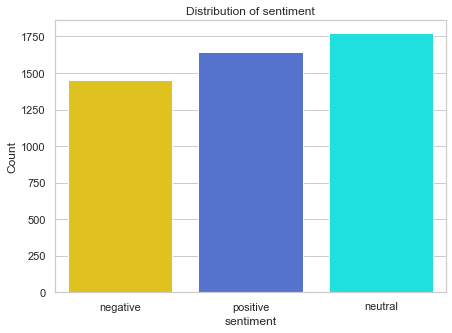

In [200]:
# Plot the distribution of LABEL values
plt.figure(figsize=(7, 5))
palette = ['gold', 'royalblue', 'aqua'] 
sns.countplot(x='sentiment', data=df, palette=palette)
plt.title('Distribution of sentiment')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.show()


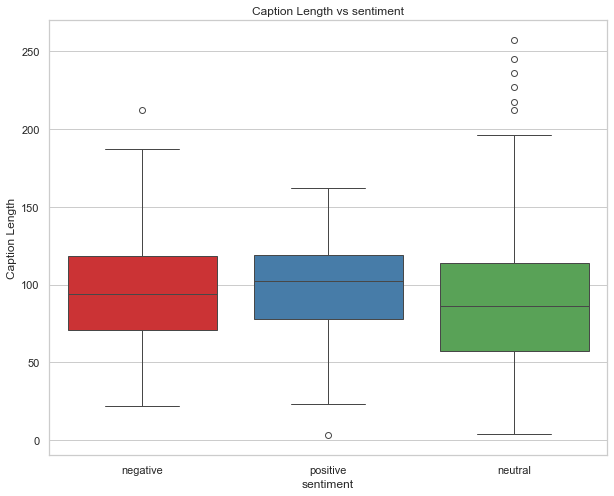

In [201]:
# Boxplot of caption length for each LABEL
plt.figure(figsize=(10, 8))
sns.boxplot(x='sentiment', y='text_length', data=df, palette='Set1')
plt.title('Caption Length vs sentiment')
plt.xlabel('sentiment')
plt.ylabel('Caption Length')
plt.show()


# Word Count vs Sentiment

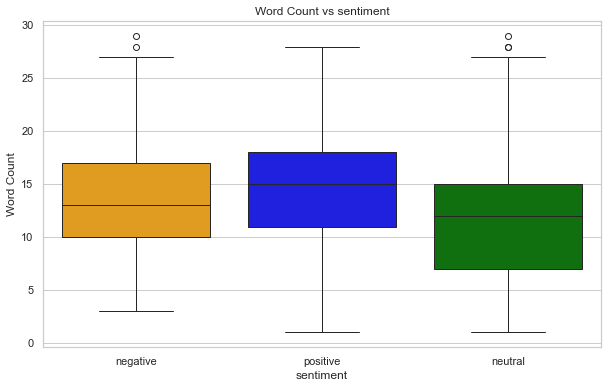

In [202]:
# Boxplot of word count for each LABEL
plt.figure(figsize=(10, 6))

palette = ['orange', 'blue', 'green']
sns.boxplot(x='sentiment', y='word_count', data=df, palette=palette)
plt.title('Word Count vs sentiment')
plt.xlabel('sentiment')
plt.ylabel('Word Count')
plt.show()


In [51]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

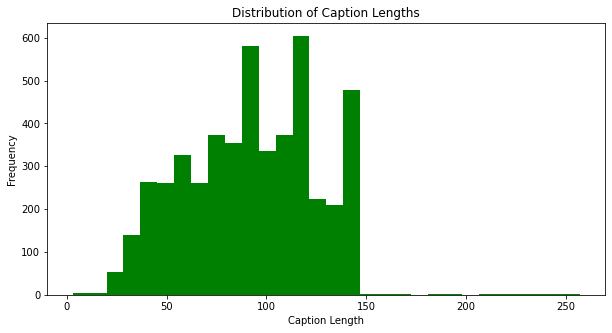

In [166]:
# Plot the distribution of caption lengths
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=30, color='green')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()


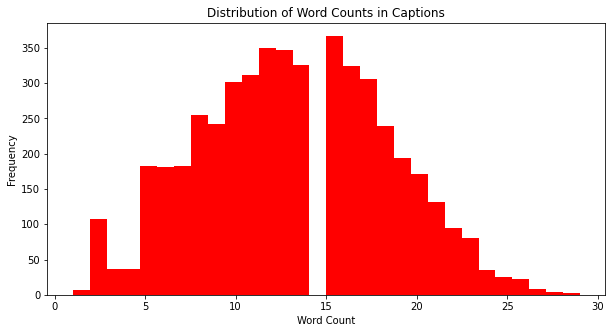

In [167]:
# Plot the distribution of word counts
plt.figure(figsize=(10, 5))
plt.hist(df['word_count'], bins=30, color='red')
plt.title('Distribution of Word Counts in Captions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


In [94]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Most Frequent Words by Sentiment (Word Clouds)

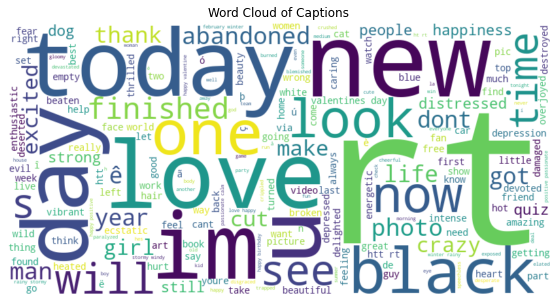

In [95]:
# Apply the clean_text function to the 'Caption' column
df['cleaned_text'] = df['text'].apply(clean_text)

# Now you can generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_text']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Captions')
plt.show()

# Correlation Heatmap (Text Length, Word Count, Sentiment Encoding)

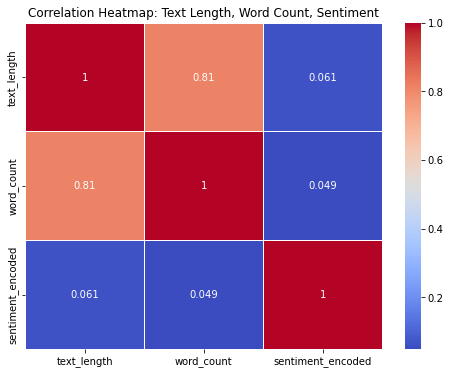

In [84]:
# Convert sentiment to numerical values with new encoding
df['sentiment_encoded'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# Correlation matrix
corr_matrix = df[['text_length', 'word_count', 'sentiment_encoded']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap: Text Length, Word Count, Sentiment')
plt.show()


# Top 15 Most Frequent Words for Each Sentiment

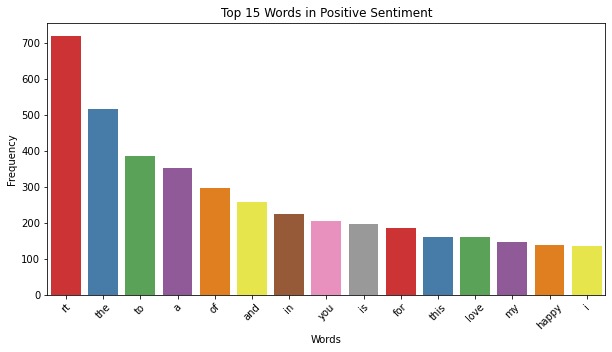

In [104]:
from collections import Counter

def plot_top_words(sentiment_label, num_words=15):
    words = ' '.join(df[df['sentiment'] == sentiment_label]['cleaned_text']).split()
    word_freq = Counter(words)
    most_common_words = word_freq.most_common(num_words)
    
    words, counts = zip(*most_common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(words), y=list(counts), palette='Set1')
    plt.title(f'Top {num_words} Words in {sentiment_label.capitalize()} Sentiment')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Plot for each sentiment
plot_top_words('positive')


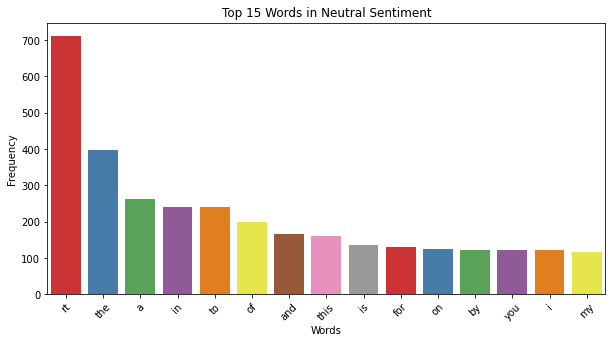

In [105]:
plot_top_words('neutral')


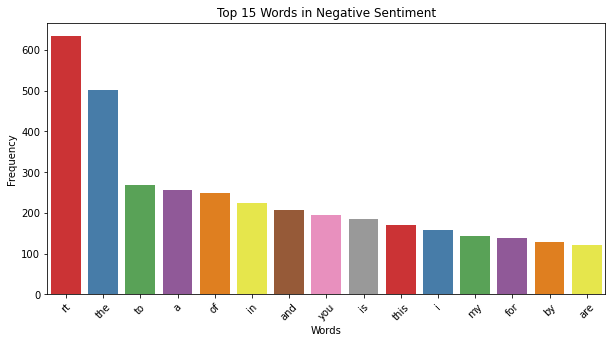

In [106]:
plot_top_words('negative')


In [102]:
df['temp_list'] = df['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,rt,2067
1,the,1417
2,to,893
3,a,872
4,of,744
5,in,688
6,and,628
7,you,522
8,is,516
9,this,491



# Text Length Distribution by Sentiment (KDE Plot)

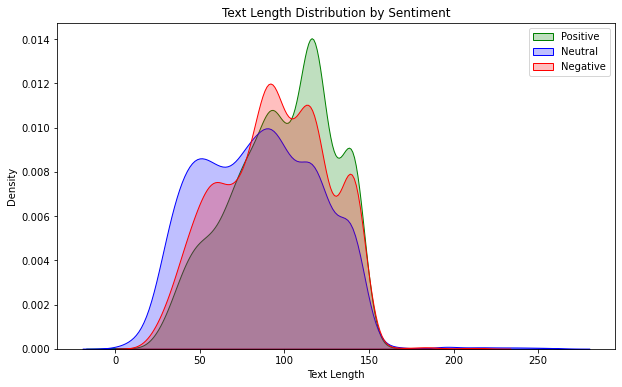

In [108]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['sentiment'] == 'positive']['text_length'], label='Positive', shade=True, color='green')
sns.kdeplot(df[df['sentiment'] == 'neutral']['text_length'], label='Neutral', shade=True, color='blue')
sns.kdeplot(df[df['sentiment'] == 'negative']['text_length'], label='Negative', shade=True, color='red')
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.legend()
plt.show()


# Pair Plot for Text Length, Word Count, and Sentiment

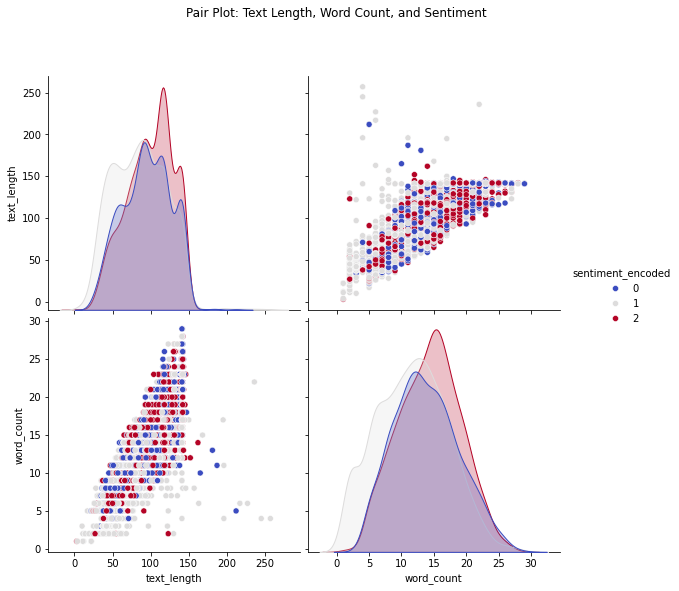

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pairplot with a larger figure size
pairplot = sns.pairplot(df[['text_length', 'word_count', 'sentiment_encoded']], 
                        hue='sentiment_encoded', 
                        palette='coolwarm', 
                        height=4)  # Default height is 2.5, adjust as needed

# Adjust the layout to prevent overlap
plt.subplots_adjust(top=0.9)  # Adjust top space if title overlaps

# Add title to the pairplot
pairplot.fig.suptitle('Pair Plot: Text Length, Word Count, and Sentiment', y=1.02)

plt.show()


# Histogram of Sentiment Distribution in Text Length and Word Count Bins

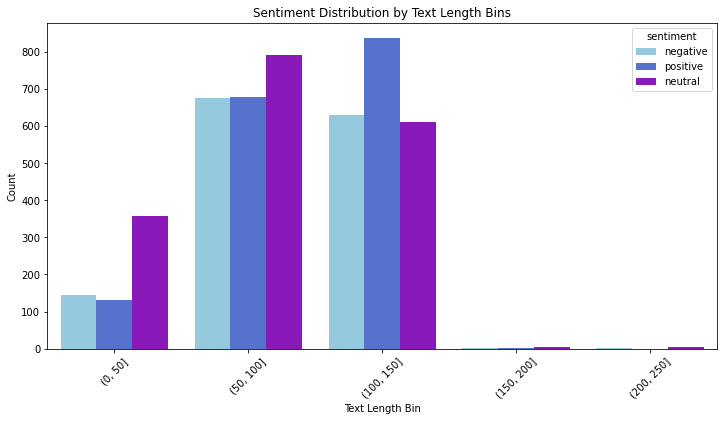

In [117]:
# Define bins for text length and word count
df['text_length_bin'] = pd.cut(df['text_length'], bins=[0, 50, 100, 150, 200, 250])
df['word_count_bin'] = pd.cut(df['word_count'], bins=[0, 10, 20, 30])

# Color palettes with good accessibility and distinct colors
text_length_palette = ['skyblue', 'royalblue', 'darkviolet', 'maroon', 'darkorange']
word_count_palette = ['gold', 'seagreen', 'darkred', 'mediumpurple']

# Plot sentiment distribution by text length bins
plt.figure(figsize=(12, 6))
sns.countplot(x='text_length_bin', hue='sentiment', data=df, palette=text_length_palette)
plt.title('Sentiment Distribution by Text Length Bins')
plt.xlabel('Text Length Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

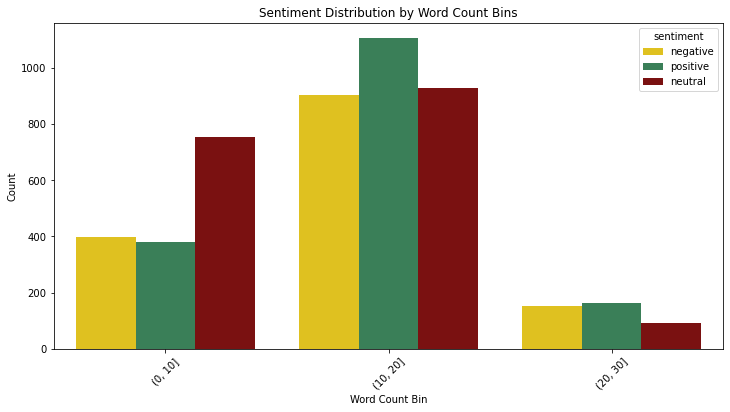

In [118]:
# Plot sentiment distribution by word count bins
plt.figure(figsize=(12, 6))
sns.countplot(x='word_count_bin', hue='sentiment', data=df, palette=word_count_palette)
plt.title('Sentiment Distribution by Word Count Bins')
plt.xlabel('Word Count Bin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Scatter Plot of Text Length vs Word Count Colored by Sentiment

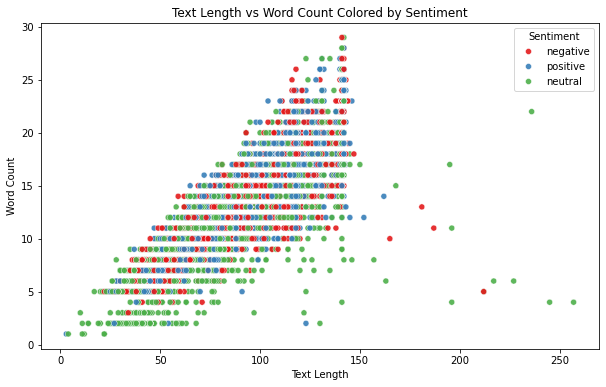

In [121]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='word_count', hue='sentiment', data=df, palette='Set1', alpha=0.9)
plt.title('Text Length vs Word Count Colored by Sentiment')
plt.xlabel('Text Length')
plt.ylabel('Word Count')
plt.legend(title='Sentiment')
plt.show()


# Visualizing the Most Common Words

In [132]:
import pandas as pd
from collections import Counter
import plotly.express as px

# Assuming 'df' is your DataFrame

# Function to get top common words for a given sentiment
def get_top_common_words(df, sentiment_label, num_words=20):
    text_data = ' '.join(df[df['sentiment'] == sentiment_label]['cleaned_text'])
    words = text_data.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    return pd.DataFrame(common_words, columns=['Common_words', 'count'])

# Prepare data for treemaps with top 20 common words
def prepare_treemap_data(df, sentiment_label):
    words_df = get_top_common_words(df, sentiment_label)
    words_df.columns = ['Common_words', 'count']
    return words_df

# Create and display treemaps for top 20 common words with reduced size
def plot_treemap(data, sentiment_label, width=800, height=600):
    fig = px.treemap(data, path=['Common_words'], values='count', title=f'Tree Map of Top 20 Most Common {sentiment_label.capitalize()} Words')
    fig.update_layout(width=width, height=height)  # Adjust size here
    fig.show()

# Generate and plot treemaps
positive_treemap_data = prepare_treemap_data(df, 'positive')
neutral_treemap_data = prepare_treemap_data(df, 'neutral')
negative_treemap_data = prepare_treemap_data(df, 'negative')

plot_treemap(positive_treemap_data, 'positive')


In [133]:
plot_treemap(neutral_treemap_data, 'neutral')



In [134]:
plot_treemap(negative_treemap_data, 'negative')

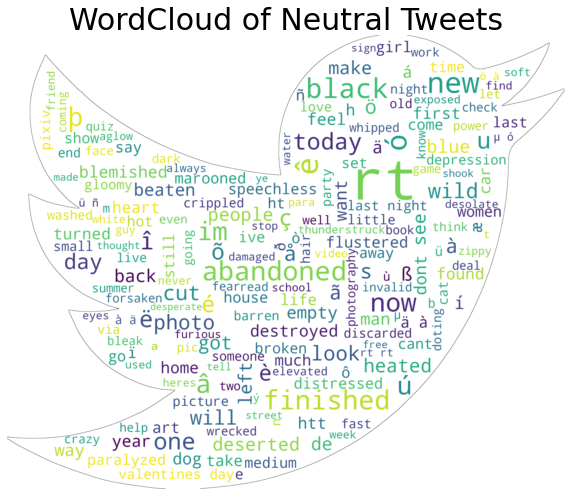

In [170]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud
def plot_wordcloud(text, mask=None, color='black', max_font_size=200, title_size=20, title="Word Cloud"):
    # Generate word cloud
    wordcloud = WordCloud(
        mask=mask,
        contour_color='black',
        contour_width=1,
        background_color=color,
        max_font_size=max_font_size,
        colormap='viridis'  # Choose a colormap if needed
    ).generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=title_size)
    plt.show()

# Load the mask image
mask_path ="D:\\Mega Folder\\sem5\\Sih\\twitter_logo.png"  # Update with the actual path to your mask image
mask = np.array(Image.open(mask_path))

# Generate and plot word cloud for neutral sentiment
plot_wordcloud(' '.join(df[df['sentiment'] == 'neutral']['cleaned_text']),
                mask=mask,
                color='white',
                max_font_size=250,
                title_size=30,
                title="WordCloud of Neutral Tweets")


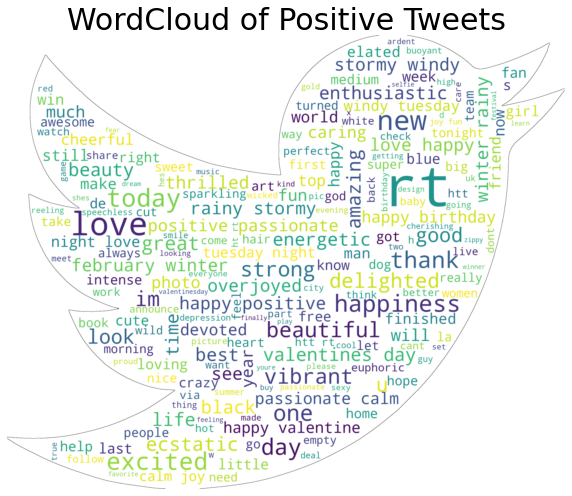

In [169]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud
def plot_wordcloud(text, mask=None, color='black', max_font_size=200, title_size=20, title="Word Cloud"):
    # Generate word cloud
    wordcloud = WordCloud(
        mask=mask,
        contour_color='black',
        contour_width=1,
        background_color=color,
        max_font_size=max_font_size,
        colormap='viridis'  # Choose a colormap if needed
    ).generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=title_size)
    plt.show()

# Load the mask image
mask_path ="D:\\Mega Folder\\sem5\\Sih\\twitter_logo.png"  # Update with the actual path to your mask image
mask = np.array(Image.open(mask_path))

# Generate and plot word cloud for neutral sentiment
plot_wordcloud(' '.join(df[df['sentiment'] == 'positive']['cleaned_text']),
                mask=mask,
                color='white',
                max_font_size=250,
                title_size=30,
                title="WordCloud of Positive Tweets")


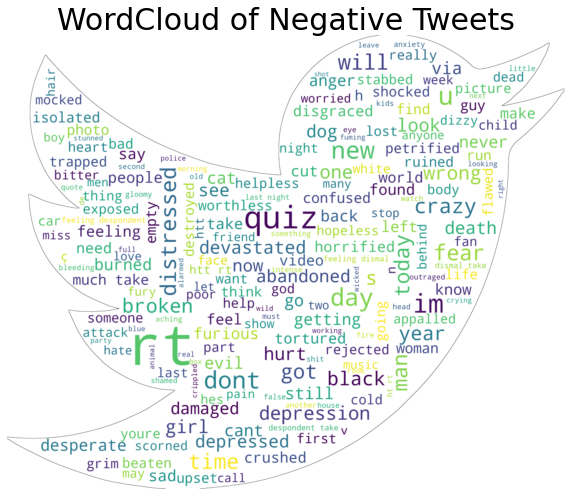

In [168]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud
def plot_wordcloud(text, mask=None, color='black', max_font_size=200, title_size=20, title="Word Cloud"):
    # Generate word cloud
    wordcloud = WordCloud(
        mask=mask,
        contour_color='black',
        contour_width=1,
        background_color=color,
        max_font_size=max_font_size,
        colormap='viridis'  # Choose a colormap if needed
    ).generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=title_size)
    plt.show()

# Load the mask image
mask_path ="D:\\Mega Folder\\sem5\\Sih\\twitter_logo.png"  # Update with the actual path to your mask image
mask = np.array(Image.open(mask_path))

# Generate and plot word cloud for neutral sentiment
plot_wordcloud(' '.join(df[df['sentiment'] == 'negative']['cleaned_text']),
                mask=mask,
                color='white',
                max_font_size=250,
                title_size=30,
                title="WordCloud of Negative Tweets")


# Distribution of Top Words in Positive Sentiment Tweets

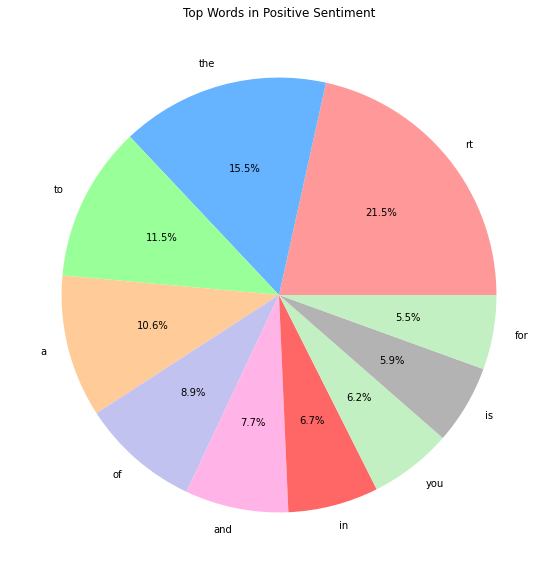

In [182]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

def plot_pie_chart(words_freq, title, colors):
    """Plot a pie chart for the most common words with specified colors."""
    # Select top 10 most common words
    top_words = dict(words_freq.most_common(10))
    
    plt.figure(figsize=(10, 10))
    plt.pie(top_words.values(), labels=top_words.keys(), autopct='%1.1f%%', colors=colors)
    plt.title(title)
    plt.show()

# Combine all texts for each sentiment
positive_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_text'])
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['cleaned_text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_text'])

# Generate word frequencies
positive_freq = Counter(positive_text.split())
neutral_freq = Counter(neutral_text.split())
negative_freq = Counter(negative_text.split())

# Define custom colors for each pie chart
positive_colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#ff6666','#c2f0c2','#b3b3b3','#c2f0c2']
neutral_colors = ['#ffcc00','#ff6666','#99ff99','#66b3ff','#c2c2f0','#ffb3e6','#ff9999','#c2f0c2','#b3b3b3','#c2f0c2']
negative_colors = ['#ff0033','#6600cc','#99ff00','#ff6600','#66ccff','#ffcc99','#cc99ff','#66ff66','#ff3399','#ffcc00']

# Plot pie charts with custom colors
plot_pie_chart(positive_freq, 'Top Words in Positive Sentiment', colors=positive_colors)



# Distribution of Top Words in Neutral Sentiment Tweets

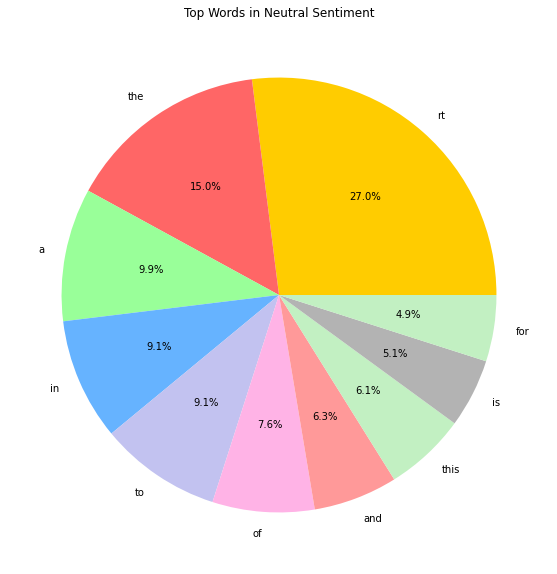

In [180]:
plot_pie_chart(neutral_freq, 'Top Words in Neutral Sentiment', colors=neutral_colors)


# Distribution of Top Words in Negative Sentiment Tweets

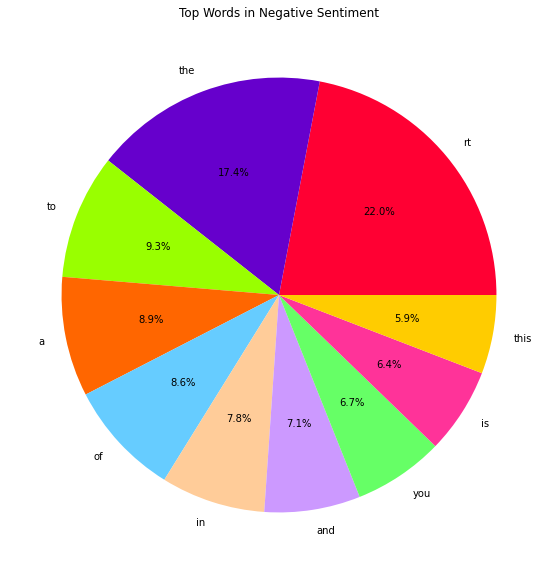

In [181]:
plot_pie_chart(negative_freq, 'Top Words in Negative Sentiment', colors=negative_colors)

In [185]:
Positive= df[df['sentiment']=='positive']
Negative = df[df['sentiment']=='negative']
Neutral =df[df['sentiment']=='neutral']

In [186]:
#MosT common negative words
top = Counter([item for sublist in Negative['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,the,502
2,to,268
3,a,257
4,of,248
5,in,224
6,and,206
7,you,194
8,is,184
9,this,169
10,i,157


In [191]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='YlOrRd')

,Common_words,count
1,the,397
2,a,261
3,in,239
4,to,239
5,of,200
6,and,165
7,this,160
8,is,135
9,for,130
10,on,125


In [188]:
#MosT common positive words
top = Counter([item for sublist in Positive['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,rt,720
1,the,518
2,to,386
3,a,354
4,of,296
5,and,257
6,in,225
7,you,206
8,is,197
9,for,185


In [196]:
heatmap_data

,sentiment_encoded,text_length,word_count
sentiment_encoded,1.000000,0.061179,0.049474
text_length,0.061179,1.000000,0.812615
word_count,0.049474,0.812615,1.000000


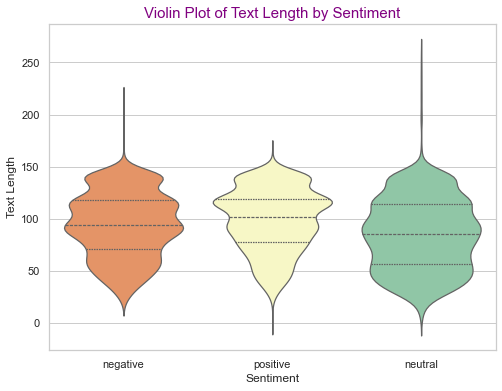

In [198]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='sentiment', y='text_length', data=df, inner='quartile', palette="Spectral")  # Color palette
plt.title('Violin Plot of Text Length by Sentiment', fontsize=15, color='purple')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Text Length', fontsize=12)
plt.show()
